# Visualizing AQI during the 2017 Thomas Fire in Santa Barbara County

[Github Repository](https://github.com/jocardelle/thomas-fire-aqi)

## About

In this task I used [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. The Thomas Fire, which burned across Santa Barbara and Ventura counties in December 2017, has been one of California’s largest wildfires, devastating over 280,000 acres of land. The fire started on December 4, 2017 and was considered contained on January 2, 2018.

## Highlights
- Combining data frames
- Selecting data form large datasets 
- Data wrangling with dates
- Visualizing time series
- Using `rolling()` to find a rolling average
- True and false color imagery

## Datasets
The first two data set contain information from the US Environmental Protection Agency(EPA) regarding AQI. They contain information regarding daily AQI by county in 2017 and 2018.

The fire perimeter data was obtained from https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436. It contains the spatial distribution of large fires in California. It covers fires that date back to 1878.

The landsat data was obtained from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2 and is from January 26, 2018. The fire perimeter data is from https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436 and was accessed through the server at `/courses/EDS220/data/hwk4_landsat_data landsat8-2018-01-26-sb-simplified.nc`. It contains the spatial distribution of large fires in California and was pre-processed to remove data outside land and coarsen the spatial resolution.


## Load necessary packages

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os              
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr

## Read in data

I imported the data directly from the urls. The data imported contains daily AQI information by county in 2017 and 2018, respectively.

In [4]:
# AQI data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

# California fire perimeters data
fp = os.path.join('data','California_Fire_Perimeters','California_Fire_Perimeters_(all).shp')
fire_perimeter = gpd.read_file(fp)

# Landsat data
fp2 = os.path.join('data','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp2)

## Air Quality Index (AQI)
### Data exploration

In order to familiarize myself with the data I used various python functions. 

In [54]:
# Return first 5 rows of `aqi_17_head`
aqi_17_head = aqi_17.head()
aqi_17_head

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,28,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,25,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,40,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,22,Good,PM2.5,01-003-0010,1


In [55]:
# Return first 5 rows of `aqi_18_head`
aqi_18_head = aqi_18.head()
aqi_18_head

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,42,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,45,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,20,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,25,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,33,Good,PM2.5,01-003-0010,1


In [56]:
# Find shape of dataframes
print(aqi_17.shape)
print(aqi_18.shape)

(326801, 10)
(327541, 10)


In [57]:
# Find number of states
print(aqi_17['State Name'].nunique())
aqi_18['State Name'].nunique()

54


54

In [58]:
# Find unique states
print(aqi_17['State Name'].unique())
print(aqi_18['State Name'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming']
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Neva

Through my data exploration I first I viewed the first five rows of each data frame to familiarize myself with the contents of each column. I then found the size of each data frame; `aqi_17` has 326801 rows and 10 colums and `aqi_18` has 327541 rows and 10 columns. Next, I looked at the number of unique `State Name` in each data frame. Both had 54 states included. Since there are only 50 states, I next looked at the unique names for each state in the data frame. For both data frames the 4 extras are `Country of Mexico`, `District of Columbia`, `Puerto Rico`, and `Virgin Islands`.

### Combine data frames

The data frames are currently separate and I want them to be combined on top of each other. I achieved this using the `pandas` function `pd.concat()` and store the combined data frame as `aqi`.

In [59]:
aqi = pd.concat([aqi_17, aqi_18])

### Data cleaning

From my initial data exploration, I viewed that there were column names with capital letters and spaces. I tidied the data to lower snake case so all column names are in lower snake case.

In [60]:
# Initial column names
print(aqi.columns, '\n')

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

# New column names
print(aqi.columns, '\n')

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object') 



### Selecting data

I selected data of interest for this project which was from just `Santa Barbara` county. I then
removed the `state_name`, `county_name`, `state_code` and `county_code` columns to leave just the `date`, `aqi`, `category`, `defining_parameter`, `defining_stie`, and `number_of_sites_reporting` columns. 

In [61]:
# Create new variable with only Santa Barbara county info 
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Remove `state_name`, `county_name`, `state_code` and `county_code`
aqi_sb = aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis=1)
aqi_sb

,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,2017-01-02,39,Good,PM2.5,06-083-2011,11
28650,2017-01-03,71,Moderate,PM10,06-083-4003,12
28651,2017-01-04,34,Good,Ozone,06-083-4003,13
28652,2017-01-05,37,Good,Ozone,06-083-4003,12
...,...,...,...,...,...,...
29128,2018-12-27,37,Good,Ozone,06-083-1025,11
29129,2018-12-28,39,Good,Ozone,06-083-1021,12
29130,2018-12-29,39,Good,Ozone,06-083-1021,12
29131,2018-12-30,41,Good,PM2.5,06-083-1008,12


Next I wanted to ensure the `date` column is a `pandas.datetime` object. I also want the index of the dataset to be the date column.

In [62]:
# view current data type of date column
aqi_sb['date'].dtype

dtype('O')

In [63]:
# Update date column to pandas.datetime and set as index
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])
aqi_sb = aqi_sb.set_index('date')

In [64]:
# confirm date column is index
aqi_sb.head()

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
date,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12
2017-01-02,39,Good,PM2.5,06-083-2011,11
2017-01-03,71,Moderate,PM10,06-083-4003,12
2017-01-04,34,Good,Ozone,06-083-4003,13
2017-01-05,37,Good,Ozone,06-083-4003,12


### Data wrangling

Next, I calculated a rolling average of the AQI over a 5 day period using the `rolling()`method for `pandas.Series`. I added it as a new column to the `aqi_sb` data frame.

In [66]:
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()
aqi_sb.head()

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,39,Good,PM2.5,06-083-2011,11,39.000000
2017-01-03,71,Moderate,PM10,06-083-4003,12,49.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.750000
2017-01-05,37,Good,Ozone,06-083-4003,12,44.000000


### Data visualization

In order to view the effects of the Thomas Fire on AQI I made a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI) using `matplotlib`.

<Axes: title={'center': 'Daily AQI vs. 5 Day Average in Santa Barbara County'}, xlabel='Date', ylabel='AQI'>

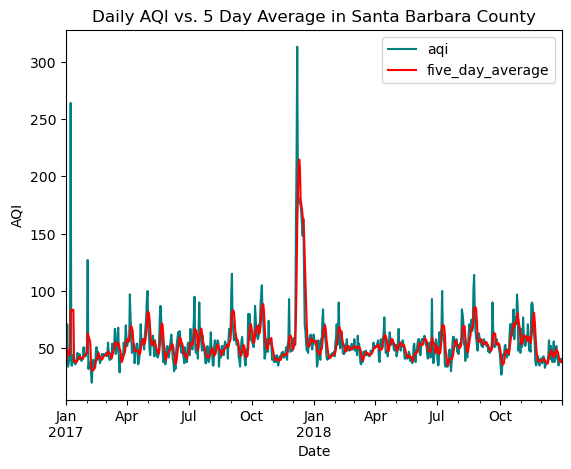

In [68]:
aqi_sb.plot(y=['aqi', 'five_day_average'],
        title = 'Daily AQI vs. 5 Day Average in Santa Barbara County',
        xlabel='Date',
        ylabel='AQI',        
        color = {'aqi':'#008080',
                 'five_day_average': '#FF0000'
                 }
        )

The above graph shows AQI in Santa Barbara County from January 2017 - December 2018. Both daily AQI and an mean AQI on a 5 day rolling basis are shown. In the graph we can see a sharp spike in AQI in December 2017. This is consistent with the time of the Thomas Fire, which took place from December 4, 2017 - January 2, 2018.

## True & false color imagery

### Data exploration

In [5]:
# Find CRS, if its projected or graphic, ellipsoid, and datum of df
print(f"{'The CRS is:':<25} {fire_perimeter.crs}")
print(f"{'Is the CRS geographic?:':<25} {fire_perimeter.crs.is_geographic}")
print(f"{'Is the CRS projected?:':<25} {fire_perimeter.crs.is_projected}")
print(f"{'ellipsoid:':<25} {fire_perimeter.crs.ellipsoid}")
print(f"{'datum:':<25} {fire_perimeter.crs.datum}")

The CRS is:               EPSG:3857
Is the CRS geographic?:   False
Is the CRS projected?:    True
ellipsoid:                WGS 84
datum:                    World Geodetic System 1984 ensemble


In [6]:
# View the first three rows of the df
fire_perimeter.head(3)

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2023,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17,2023-06-17,5,1,1,5.72913,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020,"POLYGON ((-13682443.000 5091132.739, -13682445..."
1,2023,CA,LRA,BTU,KAISER,00010225,2023-06-02,2023-06-02,5,1,1,13.60240,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020,"POLYGON ((-13576727.142 4841226.161, -13576726..."
2,2023,CA,CDF,AEU,JACKSON,00017640,2023-07-01,2023-07-02,2,1,1,27.81450,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020,"POLYGON ((-13459243.000 4621236.000, -13458968..."


In [7]:
# Find the size of the df
fire_perimeter.shape

(22261, 19)

In [8]:
# Find what years are included in the df
fire_perimeter['YEAR_'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002,
       2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991,
       1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980,
       1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969,
       1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958,
       1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947,
       1946, 1945, 1944, 1943, 1942, 1941, 1940, 1939, 1938, 1937, 1936,
       1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1926, 1925,
       1924, 1923, 1922, 1921, 1920, 1919, 1918, 1917, 1916, 1915, 1914,
       1913, 1912, 1911, 1910, 1909, 1908, 1907, 1906, 1905, 1903, 1902,
       1900, 1898, 1896, 1895, 1878,    0])

In [9]:
# Find what agencies are included in the df
fire_perimeter['AGENCY'].unique()

array(['CDF', 'LRA', 'CCO', 'FWS', 'USF', 'NPS', 'BLM', 'BIA', 'DOD',
       None, 'OTH'], dtype=object)

Through the initial data exploration, I found the CRS is EPSG 3857. I also found the data is projected and not geographic and the ellipsoid is WGS 84. I viewed the first three columns of the dataframe and was able to look at the different column names. I then looked at the shape of the df and found there are 22261 rows and 19 columns. I also looked at the years that this df covers and the yeaers span from 1878-2023 with a year 0 as well. The agencies included in this df are 'CDF', 'LRA', 'CCO', 'FWS', 'USF', 'NPS', 'BLM', 'BIA', 'DOD', 'OTH', and none.

### Selecting data

Next I want to find subset the data to contain just the information regarding the Thomas Fire of 2017.

In [12]:
# Select the Thomas Fire in 2017 and save to new variable
thomas_fire = fire_perimeter[(fire_perimeter['FIRE_NAME'] == "THOMAS") & (fire_perimeter['YEAR_'] == 2017)] 
thomas_fire.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
2654,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,9,7,1,281791.0,CONT_DATE based on Inciweb,None,None,None,None,2010,"MULTIPOLYGON (((-13316089.016 4088553.040, -13..."


### Landsat data

Now, I want to explore the leandsat data.

In [13]:
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

Through the data exploration I can see it has 4 dimensions which are band, x, y, and spatial_ref. The band and spatial_ref are `int64` and x and y are `float64`. We then have 5 data variables: red, green, blue, nir08, and swir22.

### Selecting data
I want to drop the band dimensions of the data

In [14]:
# Drop band dimension in landsat
landsat = landsat.squeeze().drop_vars("band")

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

### Match CRSs

In [19]:
# Find the CRS of the landsat and thomas_fire data
print(f"{'The CRS of landsat is:':<27} {landsat.rio.crs}")
print(f"{'The CRS of thomas_fire is:':<27} {thomas_fire.crs}")

# Reproject thomas_fire crs and verify they match
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)
print('Matched CRS?',  thomas_fire.crs == landsat.rio.crs)

The CRS of landsat is:      EPSG:32611
The CRS of thomas_fire is:  EPSG:3857
Matched CRS? True


### True color imagery

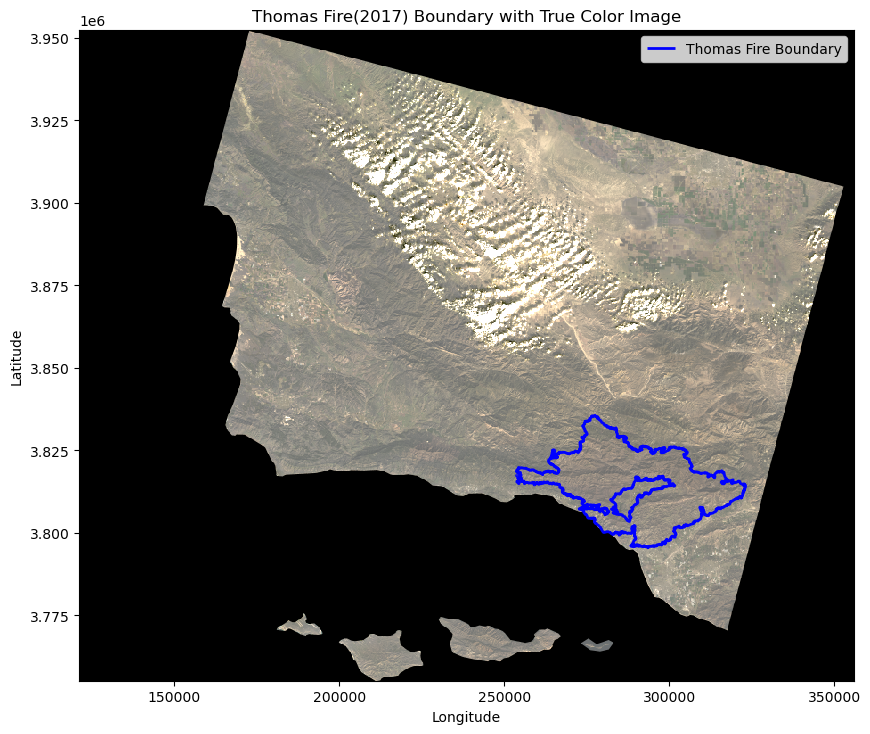

In [20]:
# Create map with ftrue color image and the Thomas Fire boundary
fig, ax = plt.subplots(figsize = (10, 10)) # Setup plot
landsat[['red', 'green', 'blue']].to_array().plot.imshow(ax = ax, robust = True) # Plot the landsat bands

thomas_fire.boundary.plot(ax = ax, edgecolor = 'blue', linewidth = 2, label="Thomas Fire Boundary") # Plot the thomas fire data on same plot

ax.set_title("Thomas Fire(2017) Boundary with True Color Image") # Set title
ax.set_xlabel("Longitude") # Set x axis label
ax.set_ylabel("Latitude")# Set y axis label
ax.legend() # Make legend

plt.show() # Show map

### False color imagery

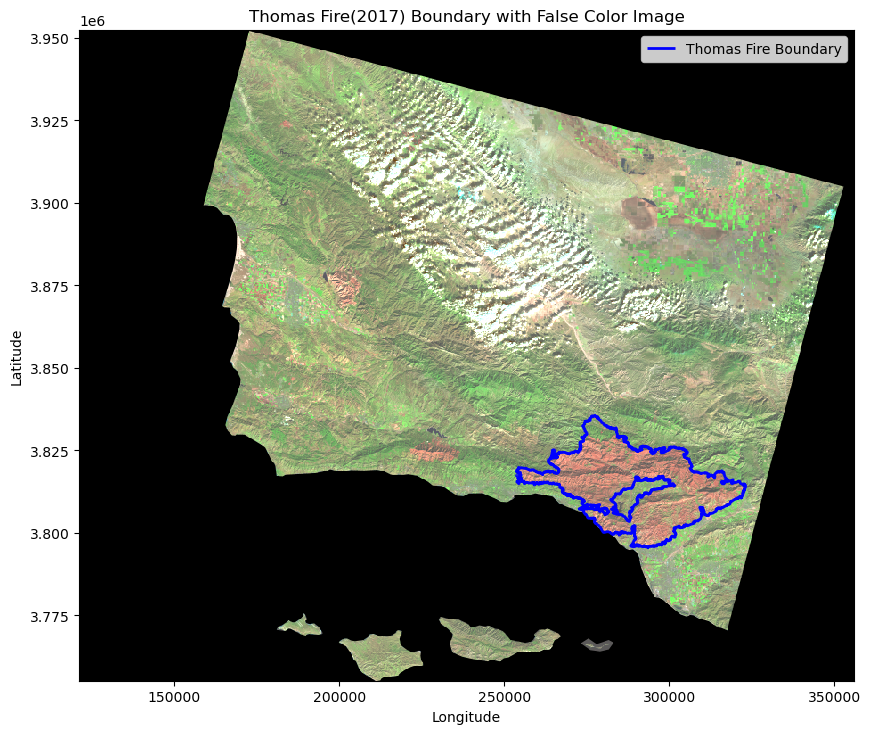

In [21]:
# Create map with false color image and the Thomas Fire boundary
fig, ax = plt.subplots(figsize = (10, 10)) # Setup plot
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, robust = True) # Plot the landsat bands

thomas_fire.boundary.plot(ax = ax, edgecolor = 'blue', linewidth = 2, label="Thomas Fire Boundary") # Plot the thomas fire data on same plot

ax.set_title("Thomas Fire(2017) Boundary with False Color Image") # Set title
ax.set_xlabel("Longitude") # Set x axis label
ax.set_ylabel("Latitude")# Set y axis label
ax.legend() # Make legend

plt.show() # Show map